# Superstore Churn — EDA + Predictive Modeling (Resume-Ready)

**Goal:** Perform end‑to‑end customer churn analysis on the Superstore dataset and build a predictive model.
            
**Contents**
1. Data loading & sanity checks
2. Exploratory Data Analysis (EDA)
3. Customer-level feature engineering (RFM-style + discounting + category mix)
4. Train/Validation split
5. Models: Logistic Regression + Random Forest
6. Evaluation: Confusion Matrix, PR/ROC, metrics table
7. Feature importance & key drivers
8. Save artifacts (engineered dataset)


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42
file_path = "./Superstore_with_churn.csv"
df = pd.read_csv(file_path)
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Ship Date"] = pd.to_datetime(df["Ship Date"], errors="coerce")


## EDA

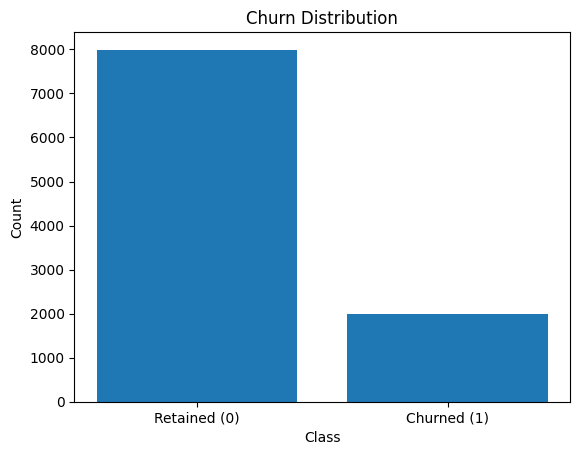

,Sales,Profit,Discount,Quantity
churn,,,,
0,229.47,26.83,0.16,3.78
1,231.42,35.94,0.15,3.83


In [13]:
churn_counts = df['churn'].value_counts()
vals = [churn_counts.get(0, 0), churn_counts.get(1, 0)]
labels = ['Retained (0)', 'Churned (1)']
plt.figure()
plt.bar(labels, vals)
plt.title('Churn Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

df.groupby('churn')[['Sales','Profit','Discount','Quantity']].mean().round(2)


## Feature Engineering (Customer-level)

In [14]:
ref_date = df['Order Date'].max()
agg = df.groupby('Customer ID').agg(
    total_sales=('Sales','sum'),
    total_profit=('Profit','sum'),
    total_orders=('Order ID','nunique'),
    total_items=('Quantity','sum'),
    avg_discount=('Discount','mean'),
    max_discount=('Discount','max'),
    first_order_date=('Order Date','min'),
    last_order_date=('Order Date','max'),
    churn=('churn','max')
).reset_index()

agg['recency_days'] = (ref_date - agg['last_order_date']).dt.days
agg['tenure_days'] = (agg['last_order_date'] - agg['first_order_date']).dt.days.replace(0,1)
agg['monthly_order_freq'] = agg['total_orders'] / (agg['tenure_days'] / 30.0)

cat_sales = df.pivot_table(index='Customer ID', columns='Category', values='Sales', aggfunc='sum', fill_value=0.0)
cat_sales = cat_sales.div(cat_sales.sum(axis=1).replace(0,1), axis=0)
cat_sales.columns = [f"share_{c.replace(' ', '')}" for c in cat_sales.columns]
seg_mode = df.groupby('Customer ID')['Segment'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) else np.nan)
reg_mode = df.groupby('Customer ID')['Region'].agg(lambda x: x.mode().iloc[0] if len(x.mode()) else np.nan)
modes = pd.concat([seg_mode, reg_mode], axis=1).rename(columns={'Segment':'Segment_mode','Region':'Region_mode'}).reset_index()
cust = agg.merge(cat_sales.reset_index(), on='Customer ID', how='left').merge(modes, on='Customer ID', how='left')
cust.head()

,Customer ID,total_sales,total_profit,total_orders,total_items,avg_discount,max_discount,first_order_date,last_order_date,churn,recency_days,tenure_days,monthly_order_freq,share_Furniture,share_OfficeSupplies,share_Technology,Segment_mode,Region_mode
0,AA-10315,5563.560,-362.8825,5,30,0.090909,0.2,2014-03-31,2017-06-29,1,184,1186,0.126476,0.002617,0.912240,0.085143,Consumer,Central
1,AA-10375,1056.390,277.3824,9,41,0.080000,0.2,2014-04-21,2017-12-11,0,19,1330,0.203008,0.026884,0.247125,0.725991,Consumer,East
2,AA-10480,1790.512,435.8274,4,36,0.016667,0.2,2014-05-04,2017-04-15,1,259,1077,0.111421,0.265455,0.349214,0.385331,Consumer,Central
3,AA-10645,5086.935,857.8033,6,64,0.063889,0.4,2014-06-22,2017-11-05,0,55,1232,0.146104,0.737323,0.192953,0.069724,Consumer,East
4,AB-10015,886.156,129.3465,3,13,0.066667,0.2,2014-02-18,2016-11-10,1,415,996,0.090361,0.440861,0.308641,0.250498,Consumer,Central


## Modeling

In [15]:
target = 'churn'
num_features = [
    'total_sales','total_profit','total_orders','total_items',
    'avg_discount','max_discount','recency_days','tenure_days','monthly_order_freq'
] + [c for c in cust.columns if c.startswith('share_')]
cat_features = ['Segment_mode','Region_mode']

X = cust[num_features + cat_features]
y = cust[target].astype(int)
X = pd.get_dummies(X, columns=cat_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

log_reg = Pipeline([('scaler', StandardScaler()), ('clf', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))])
rf = RandomForestClassifier(n_estimators=400, min_samples_split=4, class_weight='balanced', random_state=42, n_jobs=-1)

log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)

def evaluate(clf, X_te, y_te):
    preds = clf.predict(X_te)
    probs = clf.predict_proba(X_te)[:,1]
    return {
        'accuracy': accuracy_score(y_te, preds),
        'precision': precision_score(y_te, preds, zero_division=0),
        'recall': recall_score(y_te, preds, zero_division=0),
        'f1': f1_score(y_te, preds, zero_division=0),
        'roc_auc': roc_auc_score(y_te, probs)
    }

metrics = pd.DataFrame([
    {'model':'LogisticRegression', **evaluate(log_reg, X_test, y_test)},
    {'model':'RandomForest', **evaluate(rf, X_test, y_test)}
]).round(4)
metrics

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression,0.9698,0.9074,0.98,0.9423,0.9984
1,RandomForest,1.0000,1.0000,1.00,1.0000,1.0000


## ROC and PR Curves

<Figure size 640x480 with 0 Axes>

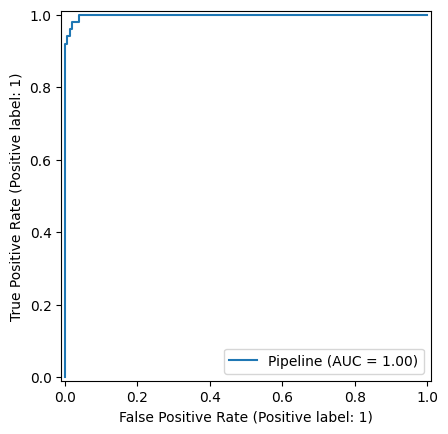

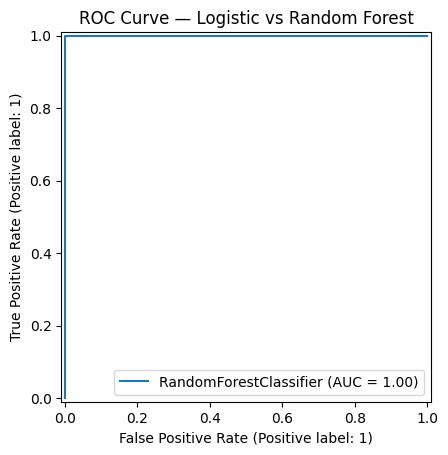

<Figure size 640x480 with 0 Axes>

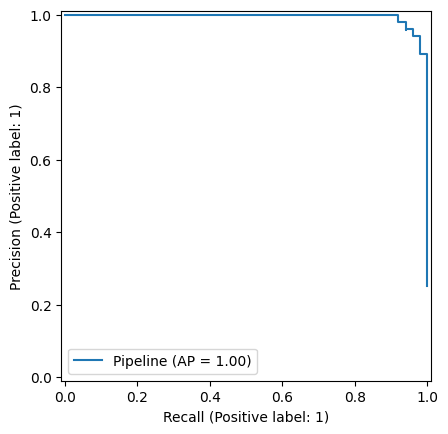

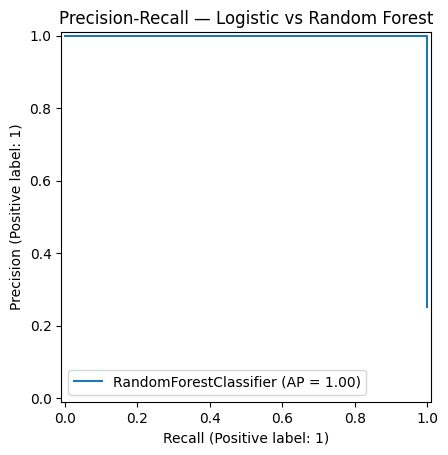

In [16]:
plt.figure()
RocCurveDisplay.from_estimator(log_reg, X_test, y_test)
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title('ROC Curve — Logistic vs Random Forest')
plt.show()

plt.figure()
PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test)
PrecisionRecallDisplay.from_estimator(rf, X_test, y_test)
plt.title('Precision-Recall — Logistic vs Random Forest')
plt.show()

## Feature Importance / Coefficients

In [17]:
import pandas as pd
rf_importance = pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False).head(20)
lr_coef = pd.DataFrame({'feature': X_train.columns, 'coef': log_reg.named_steps['clf'].coef_[0]})
lr_coef['abs_coef'] = lr_coef['coef'].abs()
lr_top = lr_coef.sort_values('abs_coef', ascending=False).head(20)
rf_importance, lr_top

(                     feature  importance
 6               recency_days    0.653673
 7                tenure_days    0.132898
 2               total_orders    0.049701
 8         monthly_order_freq    0.028408
 3                total_items    0.024839
 0                total_sales    0.022176
 1               total_profit    0.018881
 4               avg_discount    0.017043
 10      share_OfficeSupplies    0.015006
 11          share_Technology    0.014811
 9            share_Furniture    0.009905
 5               max_discount    0.005478
 14          Region_mode_East    0.001826
 16          Region_mode_West    0.001646
 12    Segment_mode_Corporate    0.001574
 15         Region_mode_South    0.001105
 13  Segment_mode_Home Office    0.001029,
                      feature      coef  abs_coef
 6               recency_days  6.571407  6.571407
 2               total_orders -0.573737  0.573737
 3                total_items  0.456506  0.456506
 14          Region_mode_East -0.411271  0.

## Save Engineered Dataset

In [ ]:
cust.to_csv('/superstore_customer_features.csv', index=False)
